# Multimodal Seach Across Collections

## Load database

In [8]:
%load_ext autoreload
%autoreload 2

In [4]:
import requests
requests.__version__

'2.31.0'

In [3]:
!pipreqs --force .

INFO: Not scanning for jupyter notebooks.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in ./requirements.txt


In [10]:
client = chromadb.PersistentClient(path="ce_vector_db")

In [11]:
db = client.get_or_create_collection(name="congruence_engine",metadata={"hnsw:space": "cosine"})

In [12]:
db.count()

11863

## Instantiate collection 

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from tools.weaving_tools import plot_images
from tools.weaving_tools import SMGCollection,NMSCollection
from PIL import Image

In [3]:
collection = SMGCollection(img_folder=Path('smg_imgs'))
collection.load_from_csv('data/SMG.csv')
collection.filter_records()

In [4]:
clip_ckpt = clip_ckpt = 'clip-ViT-B-32'#'openai/clip-vit-base-patch32'
collection.load_clip_model(clip_ckpt)

## Text Query

In [35]:
query_embedding = collection.clip_model.encode(['a communication object'])[0] # a picture of a bottle

In [17]:
#query_embedding

## Image Query

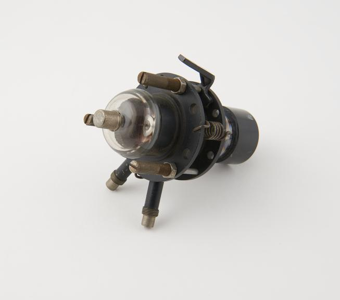

In [32]:
idx =  102
img = Image.open(collection.df['img_path'].iloc[idx])
#img = Image.open('va_imgs/2022NF4915.jpg')
query_embedding = np.array(collection.clip_model.encode(img))
img.thumbnail(size=(500,300))
img

## Query and Plot Results

In [36]:
results = db.query(
    query_embeddings=[list(query_embedding.astype(float))],
    n_results=10,
    #where={"collection": "smg"},
)

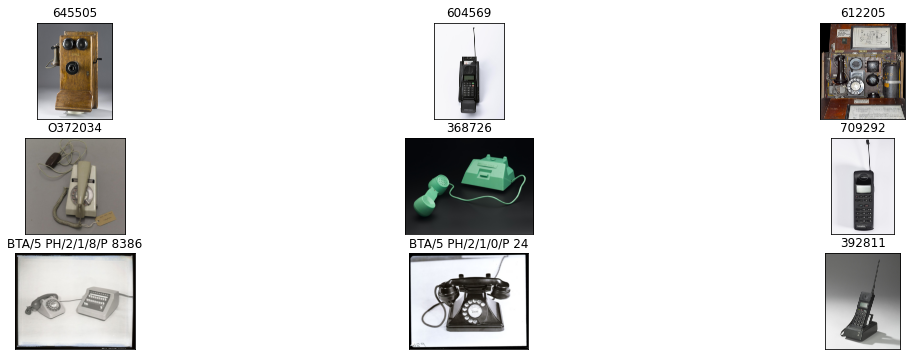

In [37]:
query_df = pd.DataFrame(results['metadatas'][0])
plot_images(query_df)

In [38]:
query_df

,collection,img_path,img_url,modality,record_id
0,nms,nms_imgs/PF4552.jpg,https://www.nms.ac.uk/search.axd?command=getco...,image,645505
1,nms,nms_imgs/PF1013549.jpg,https://www.nms.ac.uk/search.axd?command=getco...,image,604569
2,nms,nms_imgs/PF54152 .jpg,https://www.nms.ac.uk/search.axd?command=getco...,image,612205
3,va,va_imgs/2018LC0505.jpg,https://framemark.vam.ac.uk/collections/2018LC...,image,O372034
4,nms,nms_imgs/PF1026946 .jpg,https://www.nms.ac.uk/search.axd?command=getco...,image,368726
5,nms,nms_imgs/PF1004385.jpg,https://www.nms.ac.uk/search.axd?command=getco...,image,709292
6,bt,bt_imgs/TCB_473_P08386.jpg,http://www.digitalarchives.bt.com/CalmView/Get...,image,BTA/5 PH/2/1/8/P 8386
7,bt,bt_imgs/TCB_473_P00024.jpg,http://www.digitalarchives.bt.com/CalmView/Get...,image,BTA/5 PH/2/1/0/P 24
8,nms,nms_imgs/PF5069.jpg,https://www.nms.ac.uk/search.axd?command=getco...,image,392811
9,nms,nms_imgs/PF1013490 .jpg,https://www.nms.ac.uk/search.axd?command=getco...,image,604538


## Refine and Combine Query

In [39]:
nms = NMSCollection(img_folder=Path('mns_imgs'))
nms.load_from_csv('data/NMS.csv')
nms.filter_records()

In [43]:
img_paths = list(nms.df[nms.df.record_id.isin([221133, 221135])].img_path); img_paths
#img_paths = list(collection.df[collection.df.record_id.isin(['co167868'])].img_path); img_paths

['nms_imgs/PF6872.jpg', 'nms_imgs/PF6874.jpg']

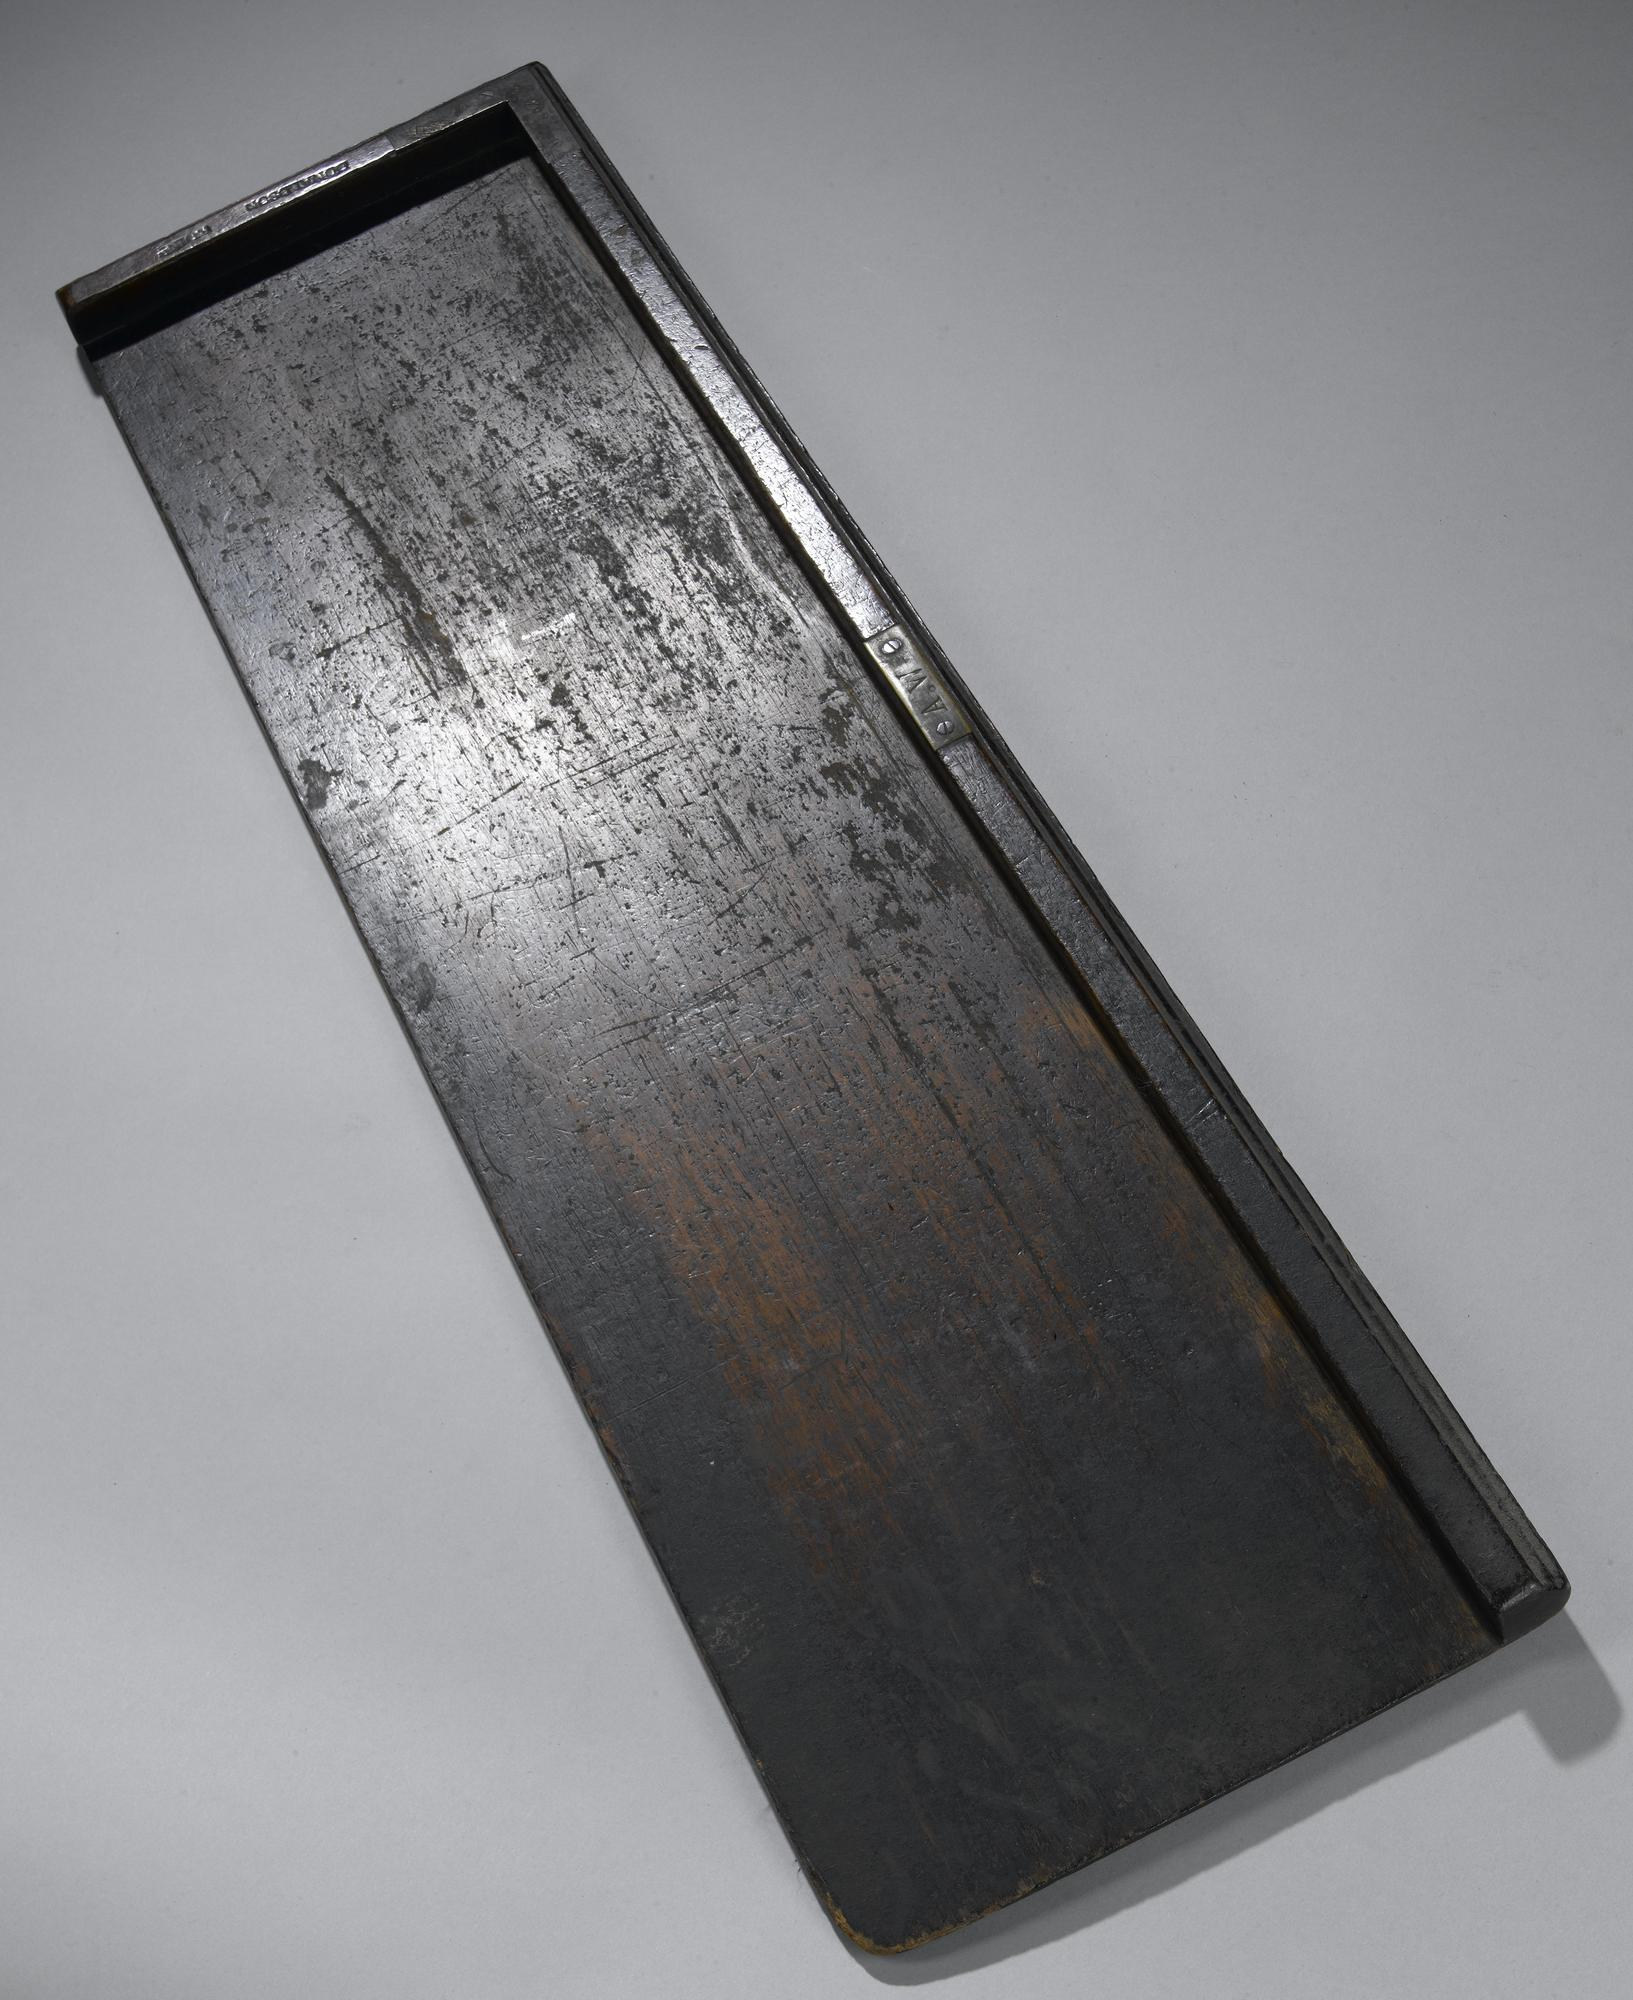

In [48]:
Image.open(img_paths[1])

In [49]:
img_paths.append('smg_imgs/324|223|medium_SMG00182131.jpg')

In [50]:
img_arrays = np.array([collection.clip_model.encode(Image.open(p)) for p in img_paths])
mean_vector = np.mean(img_arrays, axis=0)

In [51]:
mean_vector

array([-1.70931146e-01,  5.17128222e-02, -1.60599768e-01,  8.32608938e-02,
        4.03285027e-01, -1.77956119e-01,  2.33903602e-01,  5.65793097e-01,
       -3.28128529e-03,  3.08099985e-01,  2.66839355e-01, -3.03306580e-01,
        5.62792003e-01,  2.84613315e-02, -2.91696768e-02, -1.67291760e-01,
        7.69432724e-01, -1.17168449e-01, -2.77952943e-02, -5.85835457e-01,
        2.83212755e-02,  4.01847690e-01,  1.21226370e-01, -2.12035179e-01,
        1.16679689e-03,  4.57384080e-01, -2.12965205e-01, -2.86576688e-01,
       -9.24352035e-02,  7.33966827e-02, -1.91324949e-03,  2.67377466e-01,
       -2.22703338e-01, -3.03219825e-01,  3.17115486e-02, -3.00311446e-01,
       -9.26047042e-02, -2.46062830e-01,  1.03852279e-01,  5.94081342e-01,
       -1.24723397e-01, -1.96306303e-01,  4.11440045e-01, -2.45751023e-01,
        5.23791969e-01, -1.67923415e+00,  5.22370398e-01,  2.12859530e-02,
        2.14780673e-01, -1.68975160e-01,  1.74494609e-02,  1.59647071e-03,
        3.33724529e-01, -

In [52]:
results = db.query(
    query_embeddings=[list(mean_vector.astype(float))],
    n_results=10,
    #where={"collection": "nms"},
)

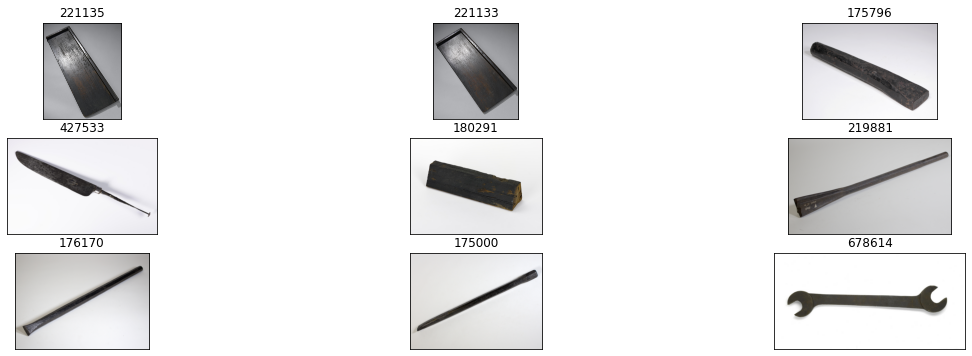

In [53]:
query_df = pd.DataFrame(results['metadatas'][0])
plot_images(query_df)

In [20]:
ids =  [5000,5001]
img_arrays = []
imgs = []
for i in ids:
    img = Image.open(collection.df.iloc[i]['img_path'])
    img_arrays.append(collection.clip_model.encode(img))
    img.thumbnail(size=(500,300))
    imgs.append(img)

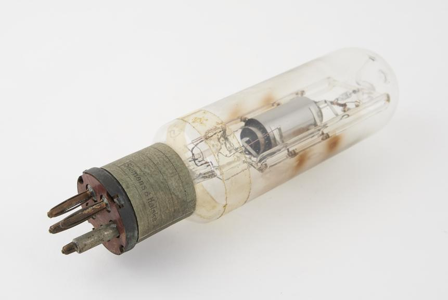

In [21]:
imgs[1]

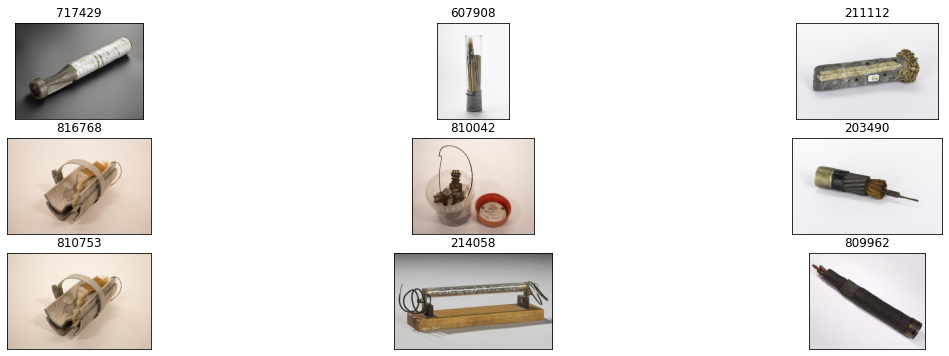

In [22]:
mean_vector = np.mean(np.array(img_arrays), axis=0)

results = db.query(
    query_embeddings=[list(mean_vector.astype(float))],
    n_results=10,
    where={"collection": "nms"},
)

query_df = pd.DataFrame(results['metadatas'][0])
plot_images(query_df)

# Fin.